---
# Homework 7
## CS 189, Spring 2021
## Author: Hieu Nguyen 
## SID: 26369732
---

# Problem 1


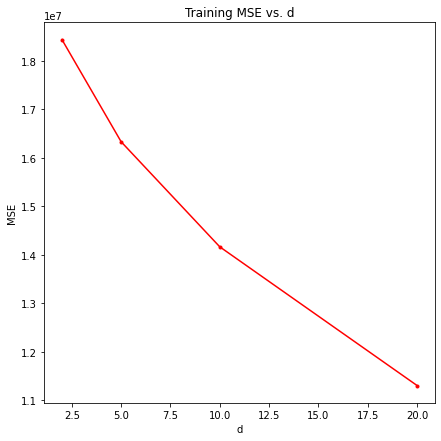

In [164]:
import os
import scipy.io
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Load training data from MAT file
R = scipy.io.loadmat('hw7_code/movie_data/movie_train.mat')['train']

# Load validation data from CSV
val_data = np.loadtxt('hw7_code/movie_data/movie_validate.txt', dtype=int, delimiter=',')

# Helper method to get training accuracy
def get_train_acc(R, user_vecs, movie_vecs):
    num_correct, total = 0, 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i, j]):
                total += 1
                if np.dot(user_vecs[i], movie_vecs[j])*R[i, j] > 0:
                    num_correct += 1
    return num_correct/total

# Helper method to get validation accuracy
def get_val_acc(val_data, user_vecs, movie_vecs):
    num_correct = 0
    for val_pt in val_data:
        user_vec = user_vecs[val_pt[0]-1]
        movie_vec = movie_vecs[val_pt[1]-1]
        est_rating = np.dot(user_vec, movie_vec)
        if est_rating*val_pt[2] > 0:
            num_correct += 1
    return num_correct/val_data.shape[0]

# Helper method to get indices of all rated movies for each user,
# and indices of all users who have rated that title for each movie
def get_rated_idxs(R):
    user_rated_idxs, movie_rated_idxs = [], []
    for i in range(R.shape[0]):
        user_rated_idxs.append(np.argwhere(~np.isnan(R[i, :])).reshape(-1))
    for j in range(R.shape[1]):
        movie_rated_idxs.append(np.argwhere(~np.isnan(R[:, j])).reshape(-1))
    return np.array(user_rated_idxs), np.array(movie_rated_idxs)


# Part (c): SVD to learn low-dimensional vector representations
def svd_lfm(R):

    # Fill in the missing values in R
    
    Rzf = np.nan_to_num(R)

    # Compute the SVD of R
    
    u, s, v = np.linalg.svd(Rzf, full_matrices=False)
    
    # Construct user and movie representations
    user_vecs  = np.multiply(u, np.sqrt(s))
    movie_vecs = np.multiply(v.T, np.sqrt(s))

    return user_vecs, movie_vecs


# Part (d): Compute the training MSE loss of a given vectorization
def get_train_mse(R, user_vecs, movie_vecs):

    # Compute the training MSE loss
    Rzf = np.nan_to_num(R)
    Rapprox = np.dot(user_vecs,movie_vecs.T)
    diff = np.square(Rapprox - Rzf)
    idx = np.logical_not(np.isnan(R))
    mse_loss = np.sum(diff[idx])
    
    return mse_loss


# Part (e): Compute training MSE and val acc of SVD LFM for various d
user_vecs, movie_vecs = svd_lfm(np.copy(R))
train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
##### TODO(e): Generate plots of train MSE and train/val accuracy for different d #####

all_d = [2,5,10,20]
train_mse = np.zeros(len(all_d))
train_acc = np.zeros(len(all_d))
val_acc = np.zeros(len(all_d))

for i,d in enumerate(all_d):
    user_vec   = user_vecs[:,:d]
    movie_vec  = movie_vecs[:,:d]
    train_mse[i] = get_train_mse(np.copy(R), user_vec, movie_vec)
    val_acc[i] = get_val_acc(val_data, user_vec, movie_vec)
    train_acc[i] = get_train_acc(np.copy(R), user_vec, movie_vec)

fig, axes = plt.subplots(1, 1, figsize=(7, 7)) 
axes.plot(all_d, train_mse, '.r-') 
axes.set_title("Training MSE vs. d") 
axes.set_xlabel("d")
axes.set_ylabel("MSE")
#plt.show()
plt.savefig("picture1.png")

fig, axes = plt.subplots(1, 1, figsize=(7, 7)) 
axes.plot(all_d, train_mse, '.r-') 
axes.set_title("Training MSE vs. d") 
axes.set_xlabel("d")
axes.set_ylabel("MSE")
#plt.show()
plt.savefig("picture1.png")

fig, axes = plt.subplots(1, 1, figsize=(7, 7)) 
axes.plot(all_d, train_acc, '.r-') 
axes.plot(all_d, val_acc, '.b-') 
axes.legend(['Training', 'Validation'], loc='upper right') 
axes.set_title("Accuracies vs. d") 
axes.set_xlabel("d")
axes.set_ylabel("Accuracy")
 # plt.ylim([0.7, .9])
#plt.show()
plt.savefig("picture2.png")

# Part (f): Learn better user/movie vector representations by minimizing loss
from numpy import linalg as LA
best_d = 10
np.random.seed(20)
user_vecs = np.random.random((R.shape[0], best_d))
movie_vecs = np.random.random((R.shape[1], best_d))
user_rated_idxs, movie_rated_idxs = get_rated_idxs(np.copy(R))

# Part (f): Function to update user vectors
def update_user_vecs(user_vecs, movie_vecs, R, user_rated_idxs):

    # Update user_vecs to the loss-minimizing value
    
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i, j]):
                 user_vecs[i] = np.multiply(R[i,j], movie_vecs[j]) / (LA.norm(movie_vecs[j]) + 1)
    return user_vecs

# Part (f): Function to update user vectors
def update_movie_vecs(user_vecs, movie_vecs, R, movie_rated_idxs):

    # Update movie_vecs to the loss-minimizing value
        for j in range(R.shape[0]):
            for i in range(R.shape[1]):
                if not np.isnan(R[j, i]):
                     movie_vecs[i] = np.multiply(R[j,i], user_vecs[j]) / (LA.norm(user_vecs[j]) + 1)
        return movie_vecs

# Part (f): Perform loss optimization using alternating updates
train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
print(f'Start optim, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')
for opt_iter in range(20):
    user_vecs = update_user_vecs(user_vecs, movie_vecs, np.copy(R), user_rated_idxs)
    movie_vecs = update_movie_vecs(user_vecs, movie_vecs, np.copy(R), movie_rated_idxs)
    train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
    train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
    val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
    print(f'Iteration {opt_iter+1}, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')

In [ ]:
# Part (f): Learn better user/movie vector representations by minimizing loss
from numpy import linalg as LA
best_d = 10
np.random.seed(20)
user_vecs = np.random.random((R.shape[0], best_d))
movie_vecs = np.random.random((R.shape[1], best_d))
user_rated_idxs, movie_rated_idxs = get_rated_idxs(np.copy(R))

# Part (f): Function to update user vectors
def update_user_vecs(user_vecs, movie_vecs, R, user_rated_idxs):

    # Update user_vecs to the loss-minimizing value
    
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i, j]):
                 user_vecs[i] = np.multiply(R[i,j], movie_vecs[j]) / (LA.norm(movie_vecs[j]) + 1)
    return user_vecs

# Part (f): Function to update user vectors
def update_movie_vecs(user_vecs, movie_vecs, R, movie_rated_idxs):

    # Update movie_vecs to the loss-minimizing value
        for j in range(R.shape[0]):
            for i in range(R.shape[1]):
                if not np.isnan(R[j, i]):
                     movie_vecs[i] = np.multiply(R[j,i], user_vecs[j]) / (LA.norm(user_vecs[j]) + 1)
        return movie_vecs

# Part (f): Perform loss optimization using alternating updates
train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
print(f'Start optim, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')
for opt_iter in range(20):
    user_vecs = update_user_vecs(user_vecs, movie_vecs, np.copy(R), user_rated_idxs)
    movie_vecs = update_movie_vecs(user_vecs, movie_vecs, np.copy(R), movie_rated_idxs)
    train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
    train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
    val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
    print(f'Iteration {opt_iter+1}, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')



<ipython-input-164-2b6e7d4e9622>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(user_rated_idxs), np.array(movie_rated_idxs)


Start optim, train MSE: 27574866.30, train accuracy: 0.5950, val accuracy: 0.5799
Iteration 1, train MSE: 125170449.89, train accuracy: 0.5526, val accuracy: 0.5344
Iteration 2, train MSE: 151731300.05, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 3, train MSE: 151079880.29, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 4, train MSE: 149832810.65, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 5, train MSE: 149236752.88, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 6, train MSE: 148922798.75, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 7, train MSE: 148744838.20, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 8, train MSE: 148639609.77, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 9, train MSE: 148575827.67, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 10, train MSE: 148536587.08, train accuracy: 0.5431, val accuracy: 0.5276
Iteration 11, train MSE: 148512224.03, train accuracy: 0.5431, val accuracy: 0.5276
